# Heat equation - Retrieving operator through ODE solving

In [229]:
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")

Main.Objectives

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [3]:
t_max = 1.0;
t_min = 0.01;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

d = 0.1;
k = 1.;
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

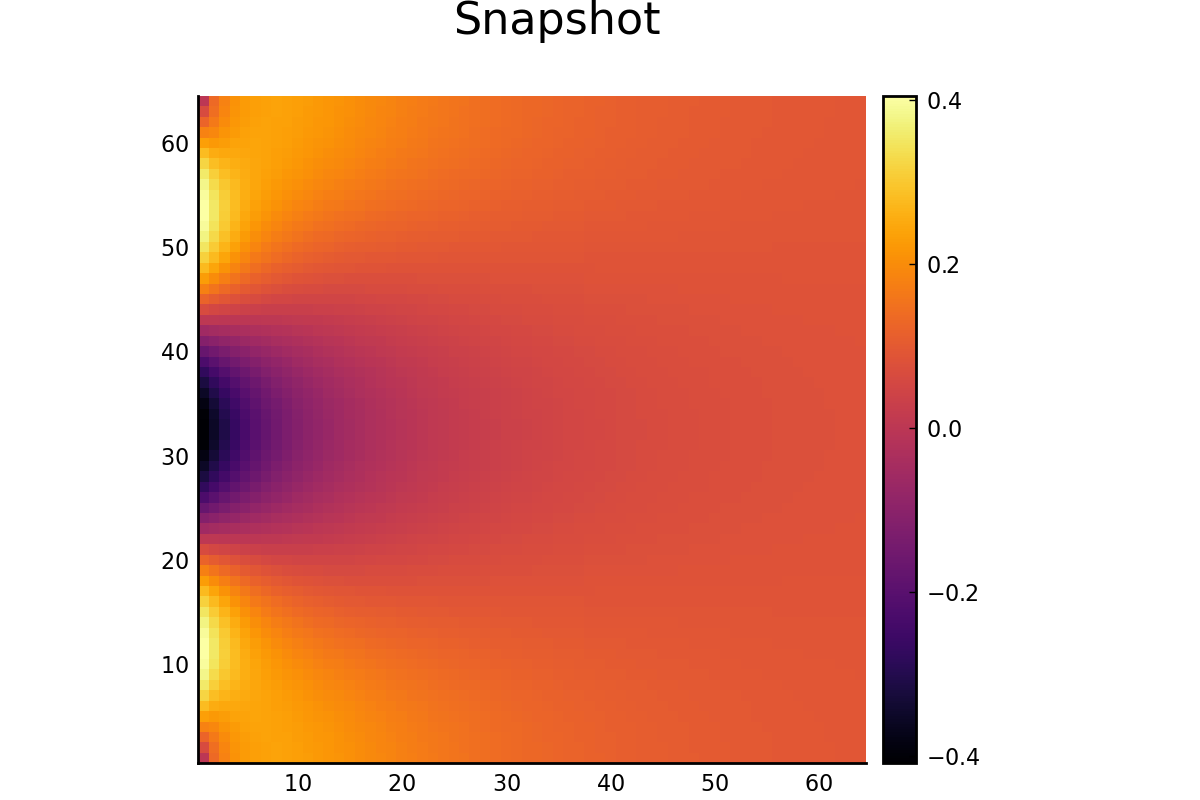

In [4]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c);
t, u = Equations.get_heat_fft(t, dx, x_n, 0.1, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

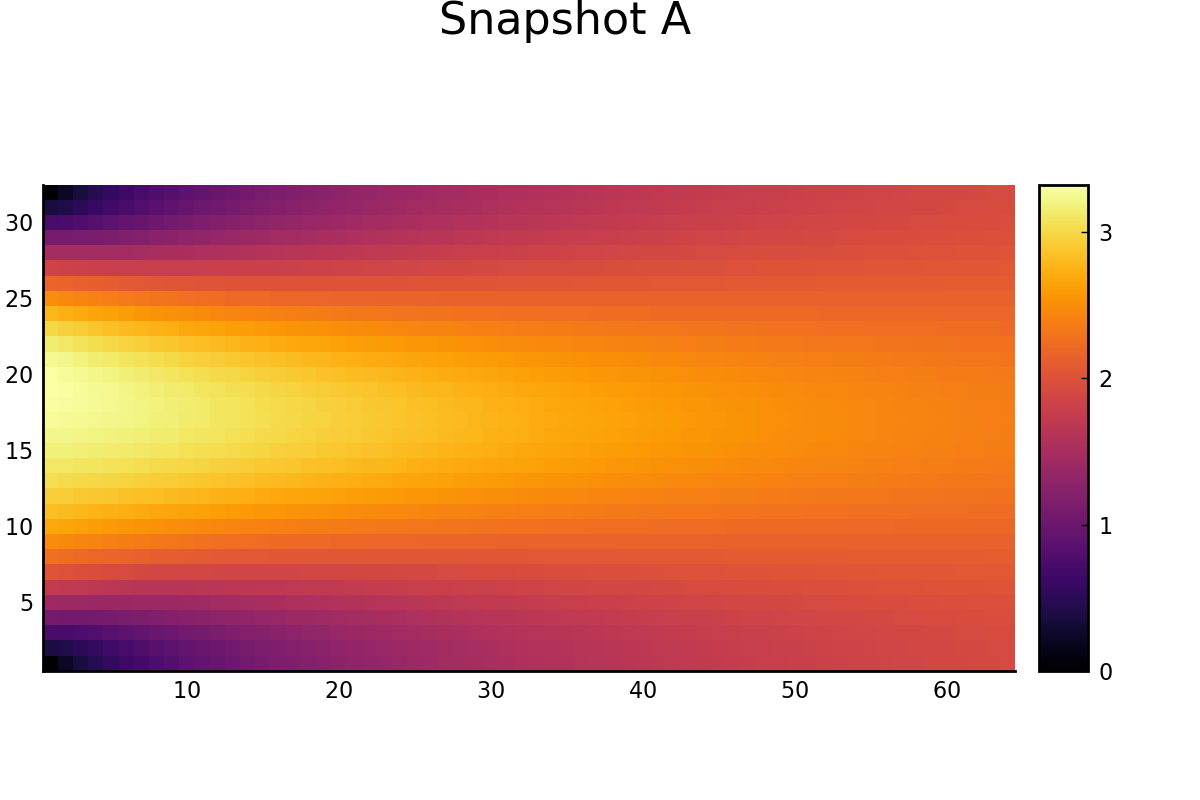

In [133]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, Int(x_n / 2), 3, 0.05, 1.);
GraphicTools.show_state(u_a, "Snapshot A")

In [136]:
print(size(u_a[:, 1]))

(32,)

## Training

In [8]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 32, 3, 0.05, 1., "heat_training_set.jld2", "training_set")

Item1Item2Item3Item4Item5Item6Item7Item8Item9Item10Item11Item12Item13Item14Item15Item16Item17Item18Item19Item20Item21Item22Item23Item24Item25Item26Item27Item28Item29Item30Item31Item32

32-element Vector{Any}:
 AbstractArray{Float64, N} where N[range(0.01, stop=1.0, length=64), [-0.06102197094626958 -0.11544702854417793 … -0.47417267208110614 -0.475790960698188; -0.10511217086849922 -0.14442972032634835 … -0.4797267166875661 -0.4811792906304333; … ; -0.05761265759314916 -0.0923345129494579 … -0.4646735827189956 -0.46657510719268896; -0.046074513055680444 -0.0982080941018811 … -0.46913887780367086 -0.47090728976424645], [0.01, 0.01388235294117647, 0.01776470588235294, 0.02164705882352941, 0.025529411764705884, 0.029411764705882353, 0.03329411764705882, 0.0371764705882353, 0.041058823529411766, 0.044941176470588234  …  0.9650588235294117, 0.9689411764705882, 0.9728235294117646, 0.9767058823529412, 0.9805882352941176, 0.9844705882352941, 0.9883529411764707, 0.9922352941176471, 0.9961176470588236, 1.0], [0.0 -0.04544858192825478 … -0.47408540919936476 -0.4744951995228677; -0.016473284229560046 -0.05116380524167366 … -0.47533516338271925 -0.47573553955964576; … ; -0.008380

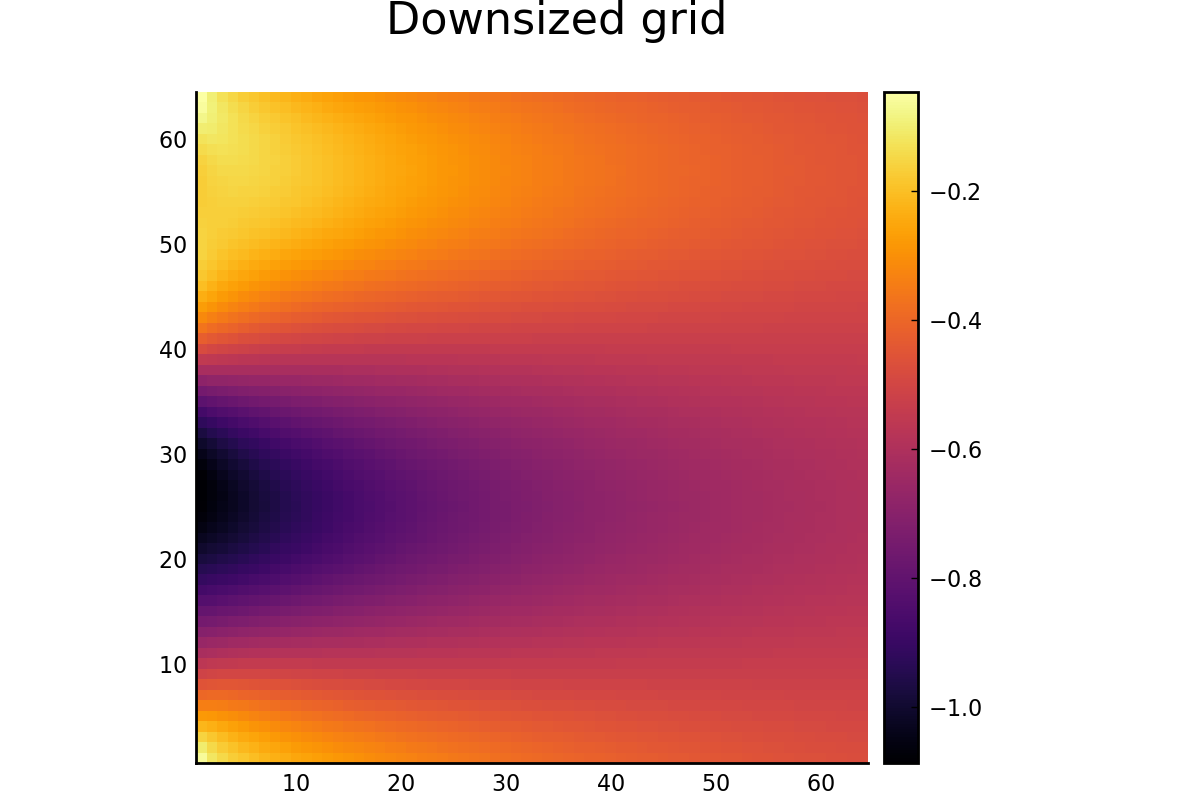

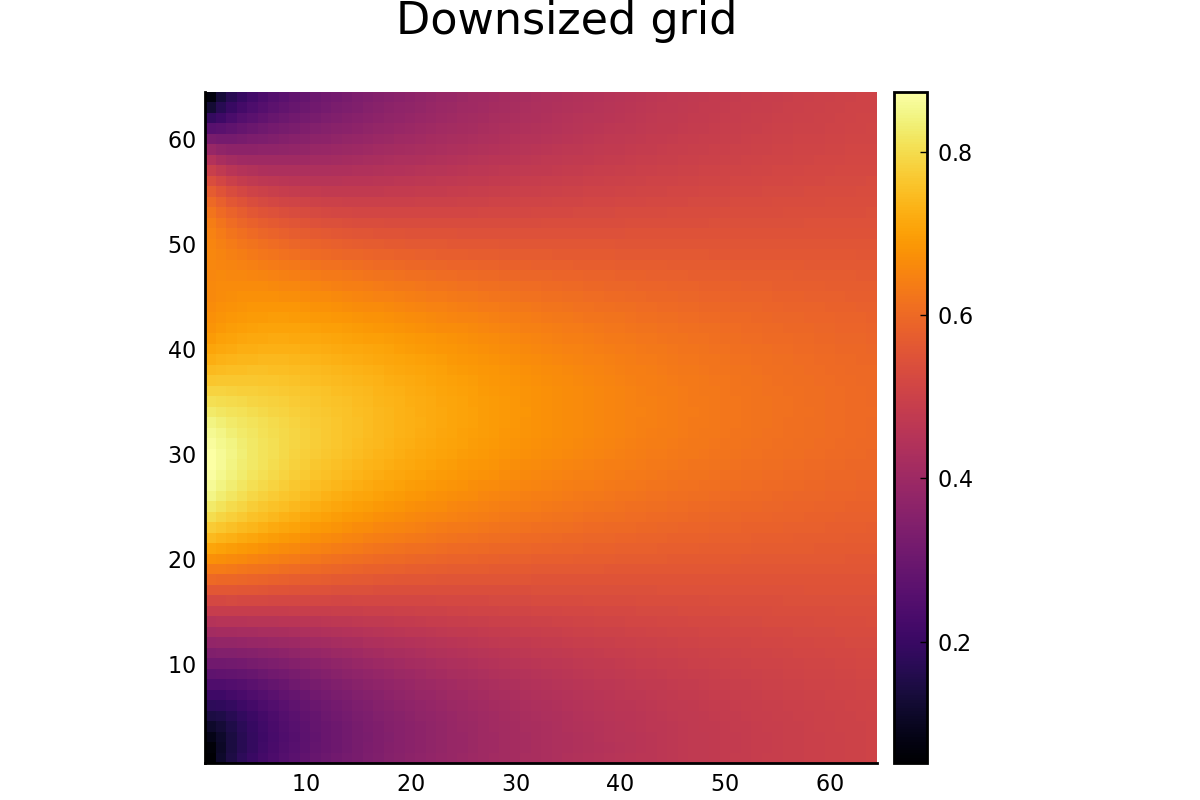

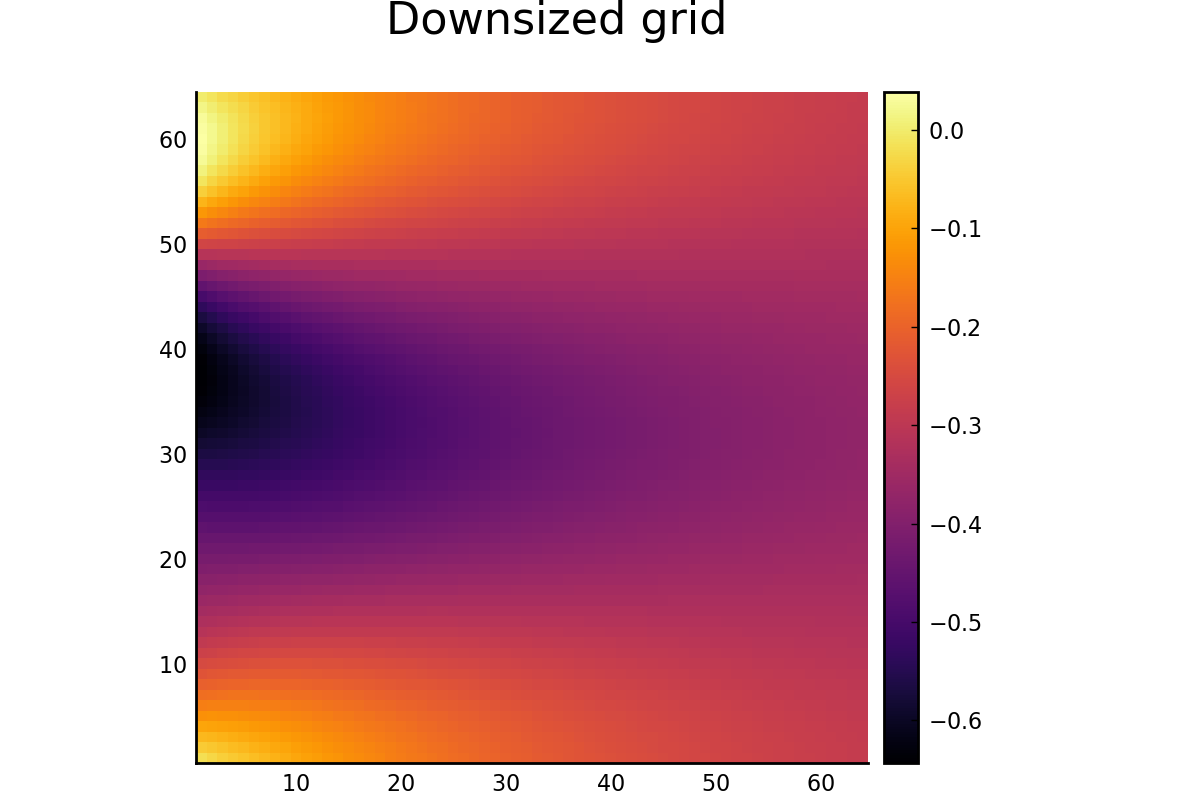

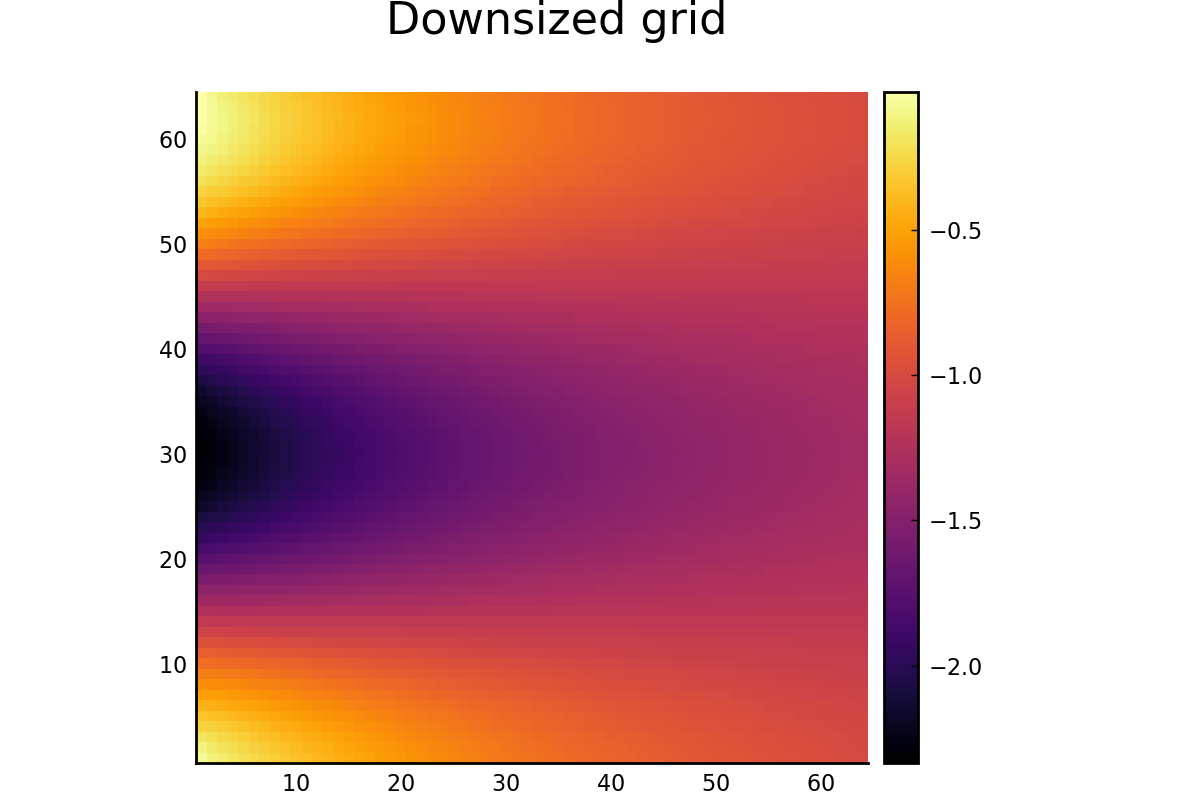

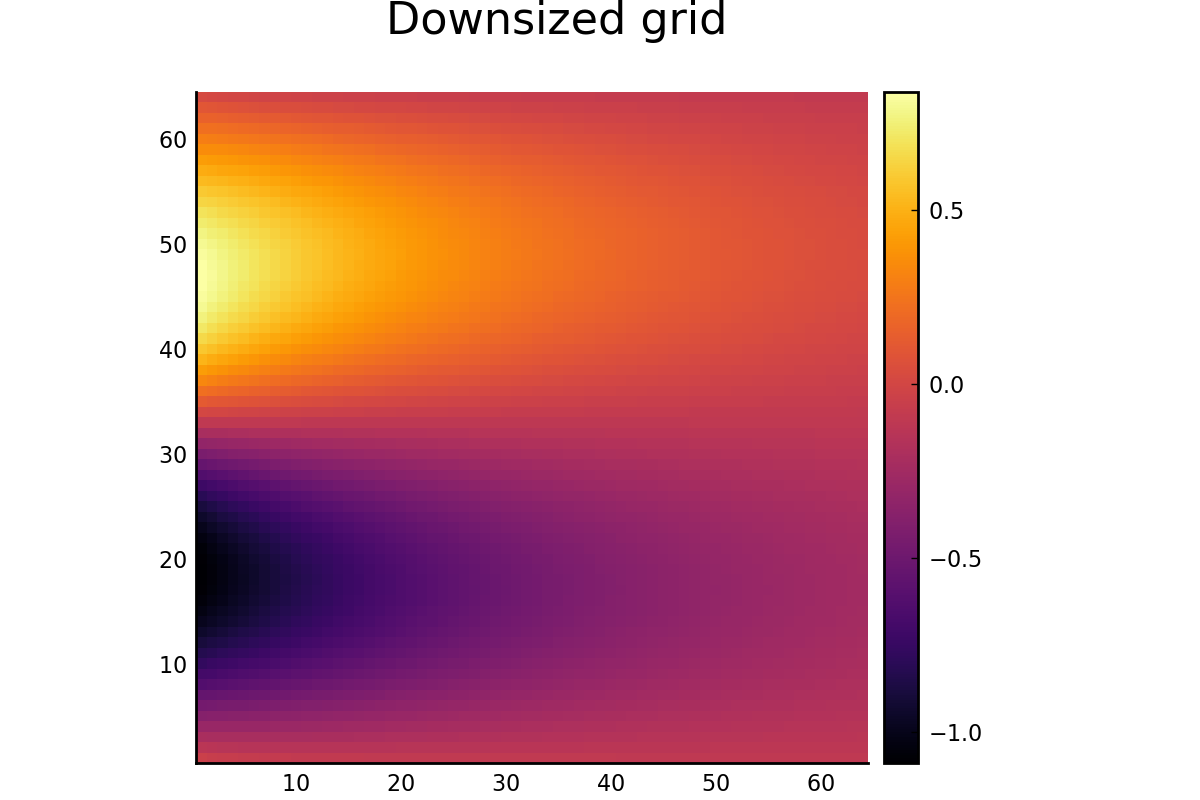

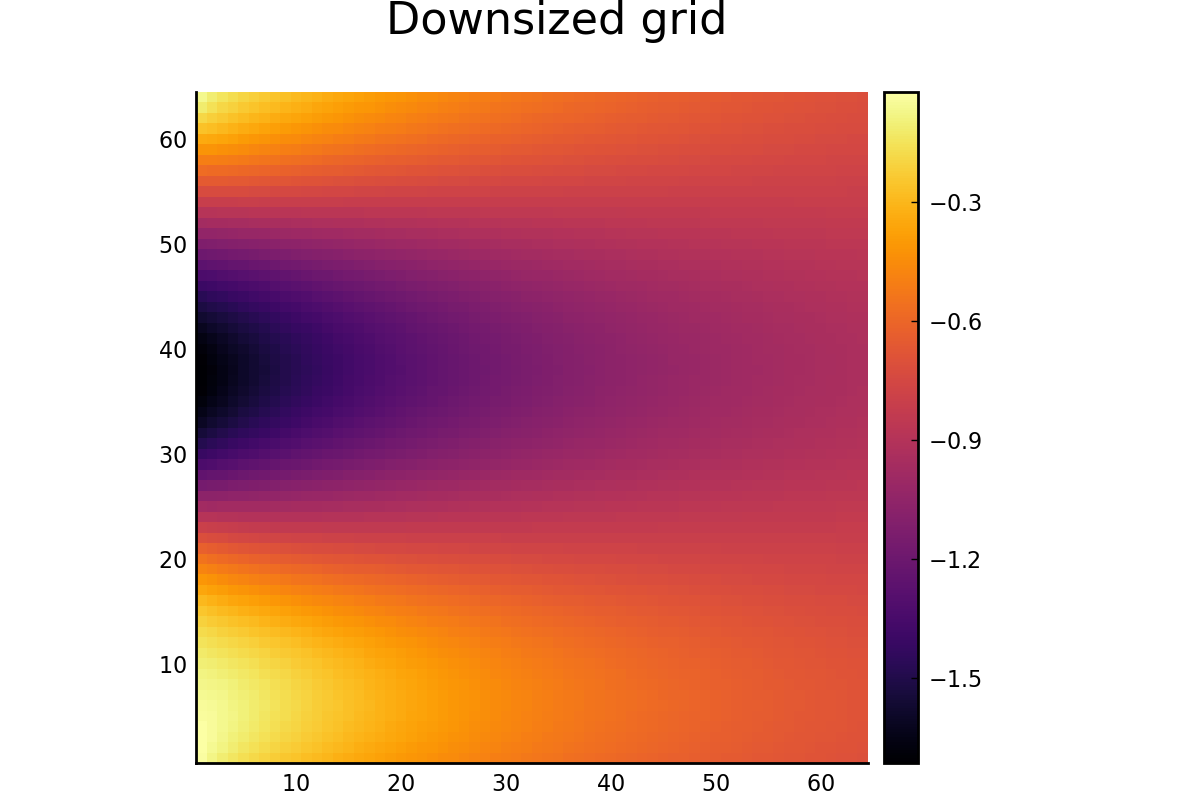

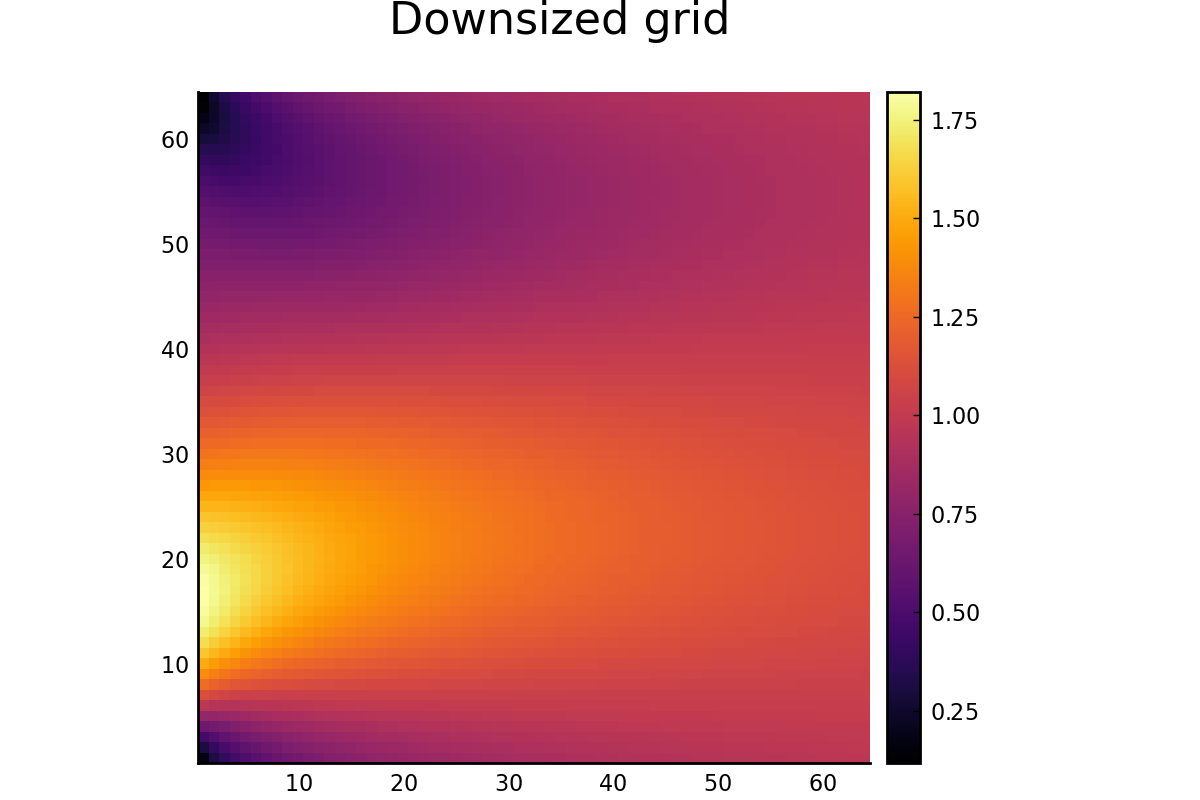

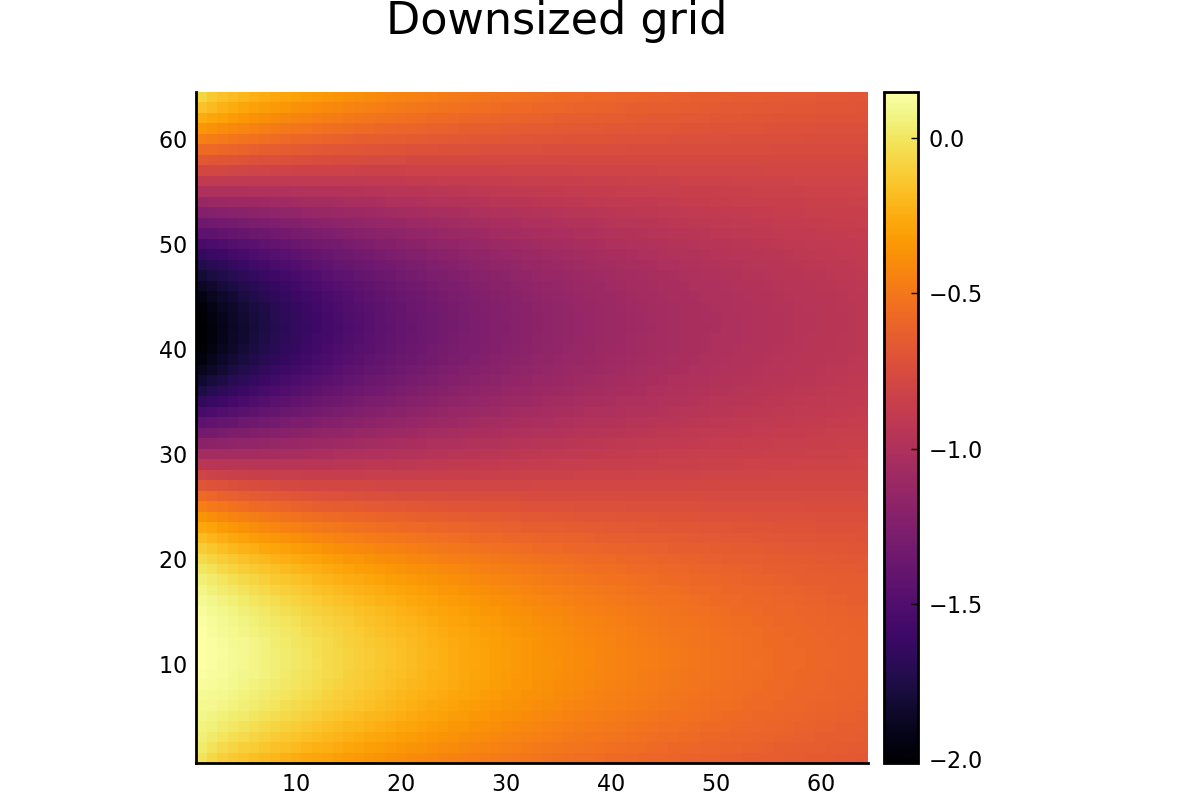

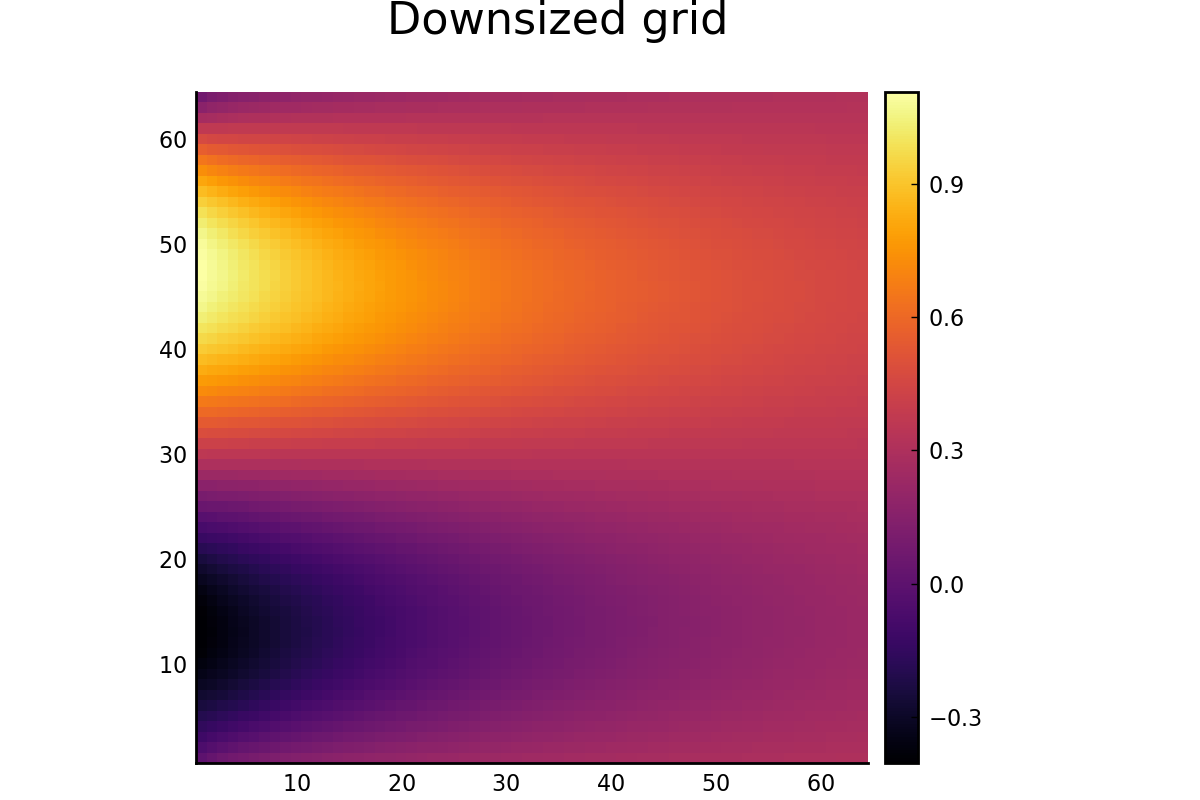

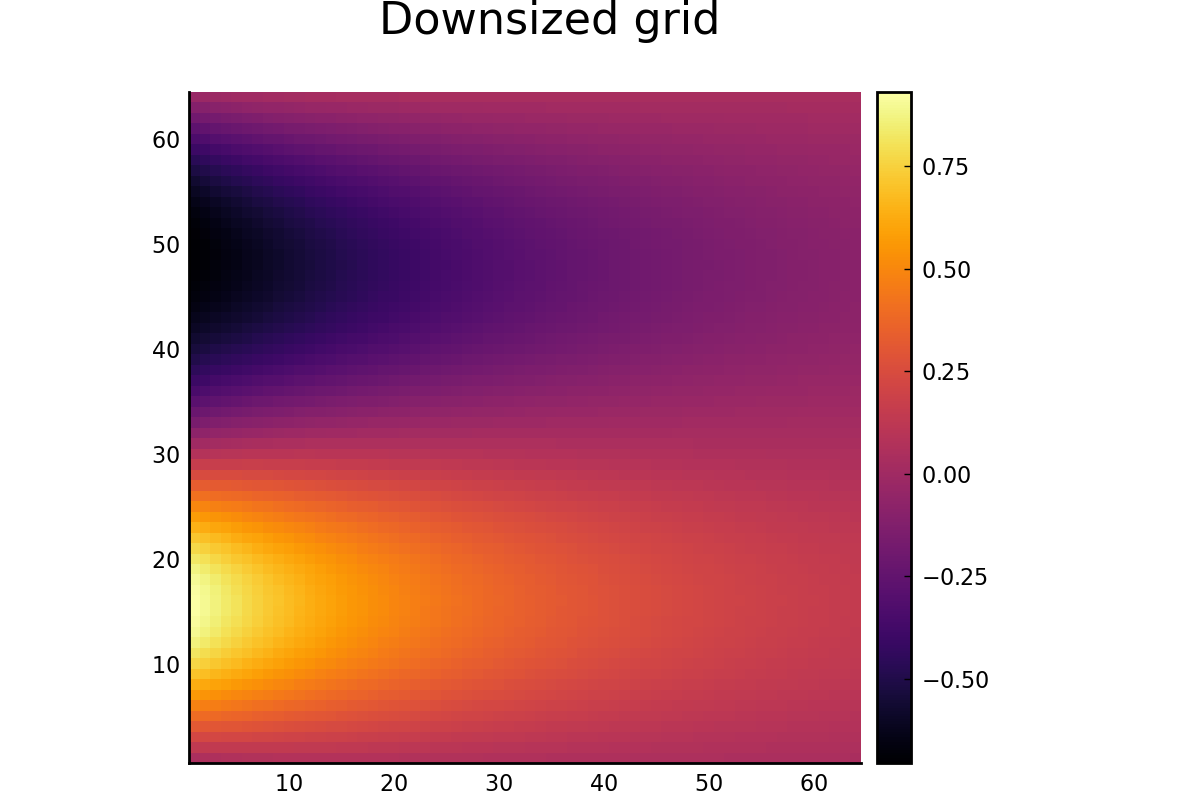

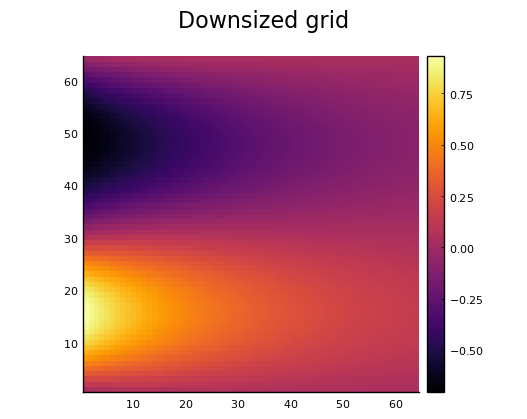

In [20]:
function check_training_dataset(dataset)
    for i in range(1, 10, step=1)
        a, b, c, d = dataset[i];
        #print("Low t  = ", collect(a), '\n')
        display(GraphicTools.show_state(b, "Downsized grid"))
    end
end

check_training_dataset(dataset)

In [160]:
function HeatModel(x_n)
  return FastChain(
    DiffEqFlux.FastDense(x_n, x_n, identity; bias=false, initW=Flux.glorot_uniform)
  )
end

HeatModel (generic function with 1 method)

In [22]:
function mseloss(u_pred, u_true)
  return sum(abs2, u_pred .- u_true) / prod(size(u_true))
end

mseloss (generic function with 1 method)

In [23]:
function f(u, K, t)
  return K * u
end

f (generic function with 1 method)

In [445]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(net), copy(u0), tspan)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 2 methods)

In [475]:
function process_dataset(dataset)
  n = size(dataset, 1)
  
  # todo - split between training and validation data
  init_set = [];
  true_set = [];
  for i in range(1, size(dataset, 1), step=1)
    t, u, _, _ = dataset[i];
    push!(init_set, u[:, 1]); # make copies ?
    push!(true_set, u); # make copies ?
  end

  t_n = size(t, 1)
  x_n = size(init_set[1], 1)

  # init_set = permutedims(hcat(init_set...), (1, 2))
  
  return t, hcat(init_set...), reshape(hcat(true_set...), :, x_n, t_n); # check dimensions
end

process_dataset (generic function with 1 method)

In [476]:
t, init_set, true_set = process_dataset(dataset);
print(size(init_set))
print(size(true_set))
#permutedims(u_true, (3, 1, 2))

(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(64, 64)(32,)(64, 32)(32, 64, 64)

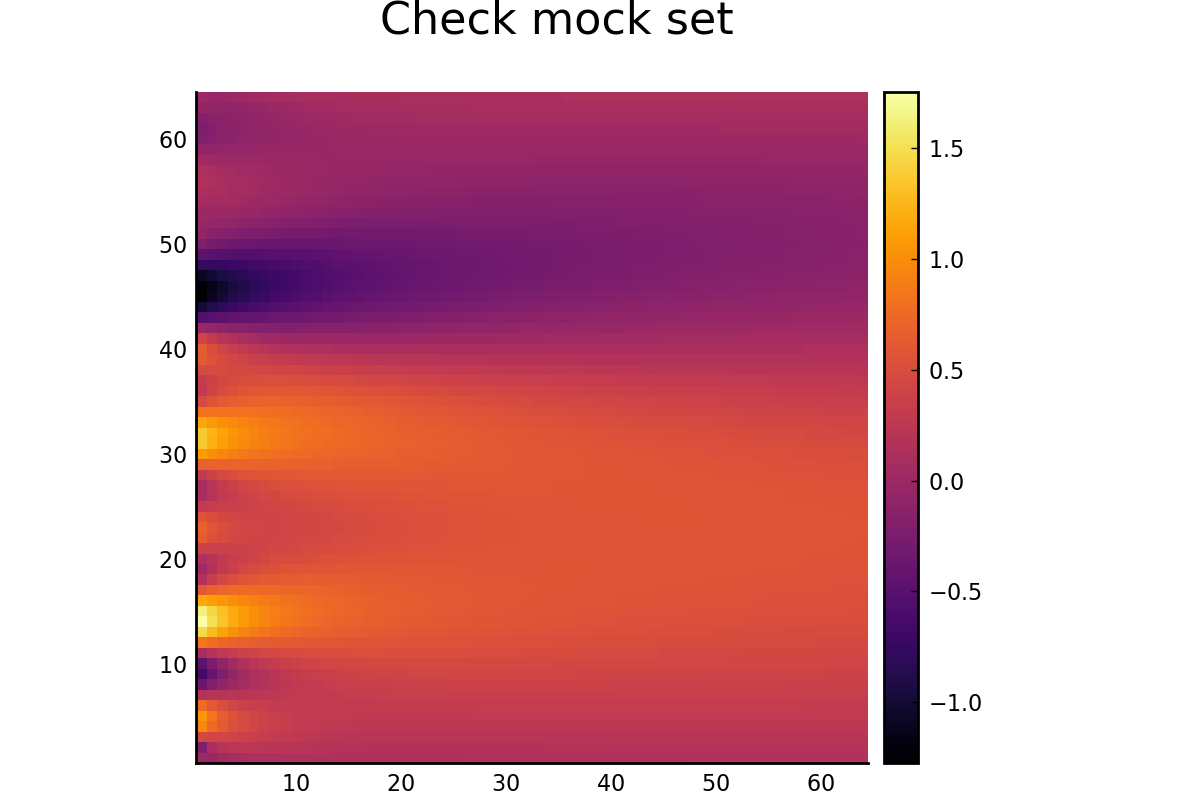

In [470]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 2, 0.01, 1.);
mock_dataset = Array([[ta, u_a, ta, u_a]]);
t, init_set, true_set = process_dataset(mock_dataset);
u_true = true_set[1, :, :];
GraphicTools.show_state(u_true, "Check mock set")

In [471]:
function callback(theta, loss, u_pred; plot_map=false)
    display(loss)    
    if plot_map
        IJulia.clear_output(true);
        display(
            plot(
                GraphicTools.show_state(u_pred, "Predict"),
                GraphicTools.show_state(u_true, "Reference");
                layout = (1, 2),
            ),
        )
    end
    
    #     t_plot = range(1; )
#     for (i, t) in enumerate(tplot)
#         plot!(p, xfine, u.(xfine, t); color = i, label = nothing)
#         scatter!(p, x, sol[i]; label = "t = $t", color = i, markeralpha = 0.5)
#     end
#     pl = scatter(t, u_true[:, 2], label = "data");
#     scatter!(pl, t, u_pred[:, 2], label = "prediction");

  return false
end

callback (generic function with 2 methods)

In [472]:
function callback(theta, loss)  
    IJulia.clear_output(true);
    display(loss);
  return false
end

callback (generic function with 2 methods)

In [473]:
function heat_training(net, epochs, dataset)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  t, u0, u_true = process_dataset(dataset)
#   u02 = u0[1]
#   u_true2 = Array(u_true[1])

  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    print("predict")
    u_pred = predict_neural_ode(theta)
    print("after predict")
    l = Objectives.mseloss(u_pred, u_true)
    print("after loss")
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  #callback(result.minimizer, loss(result.minimizer)...; plot_map=true)
  return result
end

heat_training (generic function with 1 method)

In [474]:
net = HeatModel(64);
result = heat_training(net, 10, dataset);

predictafter predict

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 64 and 32")

In [450]:
t, u0, u_true = process_dataset(dataset)
sol = S(net, u0[1], t)
display(
    plot(
        show_state(u_true[1], "Data"),
        show_state(sol, "Prediction")
    )
)

# function loss(theta)
#  u_pred = predict_neural_ode(theta)
#  l = Objectives.mseloss(u_pred, u_true)
#  return l, u_pred
# end

# callback(result.minimizer, loss(result.minimizer)...; plot_map=true)

LoadError: MethodError: no method matching (::FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}})(::Float64, ::SciMLBase.NullParameters, ::Float64)
[0mClosest candidates are:
[0m  (::FastChain)(::Any, ::Any) at /Users/vdesgrange/.julia/packages/DiffEqFlux/b5yNs/src/fast_layers.jl:21

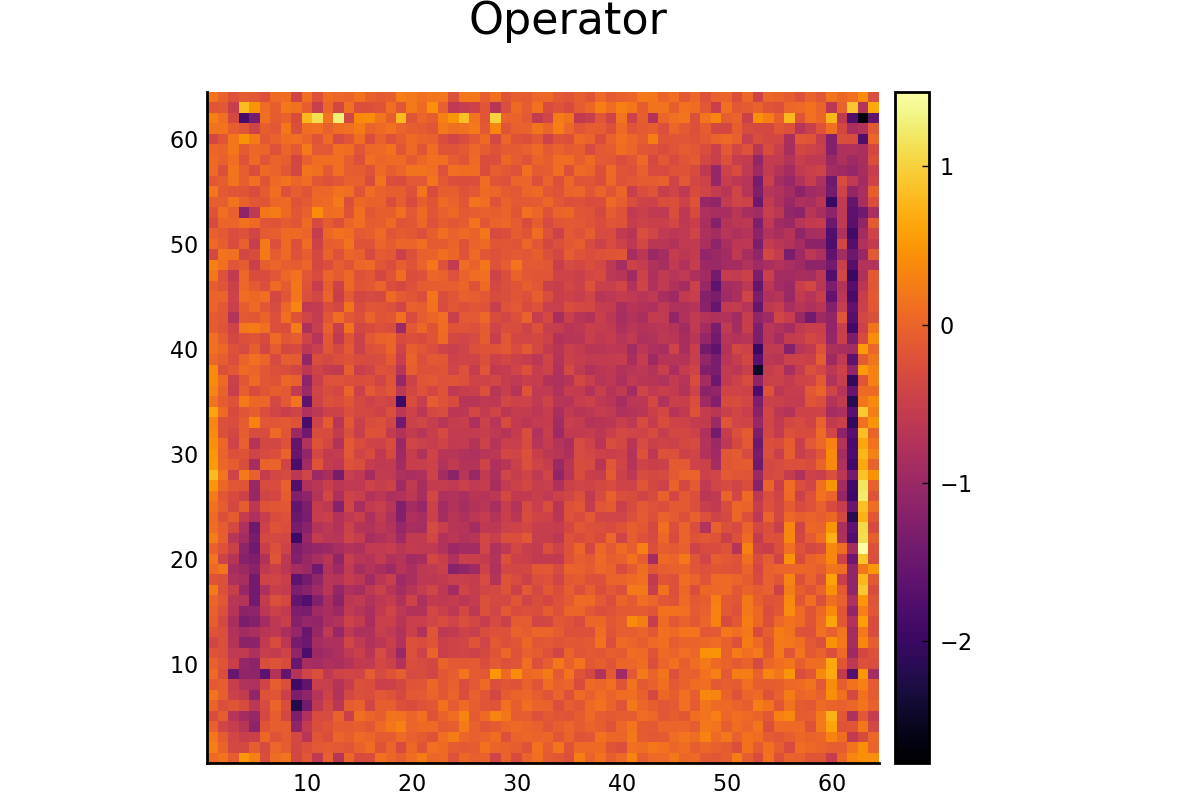

In [452]:
GraphicTools.show_state(reshape(result.u, (64, 64)), "Operator")